In [180]:
import glob
import pandas as pd
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

# Leading SPACE!!!
angle_type_prefix = ' pose_R'
angle_type_prefix = ' p_r'


In [247]:
def get_peaks_params(head_class, angle_type):

    FRAME_RATE = 30
    all_widths = []
    all_heights = []

    for csv_file in glob.glob('./data/' + head_class + '/*.csv'):
        df = pd.read_csv(csv_file)

        # Resample to common frame rate
        csv_frame_rate = (df.shape[0] - 1) / np.sum(np.diff(df[' timestamp']))
        # print('csv frame rate: ', csv_frame_rate)
        n_resampled_points = int(1 + (len(df[angle_type]) - 1) * FRAME_RATE / csv_frame_rate)
        angles = scipy.signal.resample(df[angle_type], num=n_resampled_points)
        
        # Filter
        angles = scipy.signal.medfilt(angles, kernel_size=19)

#         fc = 5
#         b, a = scipy.signal.butter(N=2, Wn=2*fc/FRAME_RATE, btype='low', analog=False, output='ba')
#         angles = scipy.signal.filtfilt(b, a, angles)
        
        # Get peak locations, widths, and heights
        peaks, _ = scipy.signal.find_peaks(angles)
        widths, _, _, _ = scipy.signal.peak_widths(angles, peaks)
        heights, _, _ = scipy.signal.peak_prominences(angles, peaks)
        
        all_widths.extend(widths)
        all_heights.extend(heights)

    return all_widths, all_heights


In [248]:
def optimize_threshold(pos_data, neg_data, threshold_range):    
    """
    For each threshold calculate F1 measure to find the optimal threshold value.
    
    pos_data are assumed to be above the threshold, i.e. the positive class
    """
    
    best_F1, best_P, best_R = 0., 0., 0.
    for threshold in threshold_range:
        
        TP = sum(i > threshold for i in pos_data)
        TN = sum(i <= threshold for i in neg_data)
        FN = len(pos_data) - TP
        FP = len(neg_data) - TN
        
        P = TP / (TP + FP)
        R = TP / (TP + FN)
        F1 = 2 * ((P * R) / (P + R))
        
        if F1 > best_F1:
            best_threshold, best_F1, best_P, best_R = threshold, F1, P, R

    print(f'Best threshold: {best_threshold}\n\tF1: {best_F1}\tP: {best_P}\tR: {best_R}')
    
    return best_threshold, best_F1, best_P, best_R


# 1. Nod vs other

In [249]:
nod_x_widths,   nod_x_heights   = get_peaks_params(head_class='nod',   angle_type=angle_type_prefix+'x')
other_x_widths, other_x_heights = get_peaks_params(head_class='other', angle_type=angle_type_prefix+'x')


In [250]:
width_threshold_range = np.arange(0, 20, 0.02)
height_threshold_range = np.arange(0, 0.1, 0.0001)

In [251]:
print('PEAK WIDTHS:')
width_threshold, _, _, _ = optimize_threshold(nod_x_widths, other_x_widths, threshold_range=width_threshold_range)

PEAK WIDTHS:
Best threshold: 2.18
	F1: 0.8255613126079447	P: 0.7071005917159763	R: 0.991701244813278


In [252]:
print('PEAK HEIGHTS:')
height_threshold, _, _, _ = optimize_threshold(nod_x_heights, other_x_heights, threshold_range=height_threshold_range)

PEAK HEIGHTS:
Best threshold: 0.0032
	F1: 0.8527724665391969	P: 0.7907801418439716	R: 0.9253112033195021


In [254]:
# Decision based on both thresholds

TP = sum(w > width_threshold and h > height_threshold  for w, h in zip(nod_x_widths,   nod_x_heights))
TN = sum(w <= width_threshold or h <= height_threshold for w, h in zip(other_x_widths, other_x_heights))
FN = len(nod_x_widths) - TP
FP = len(other_x_widths) - TN

P = TP / (TP + FP)
R = TP / (TP + FN)
F1 = 2 * ((P * R) / (P + R))
print(f'Joint F1 measure: {F1}')

Joint F1 measure: 0.8516377649325626


Distribution of peak widths and heights


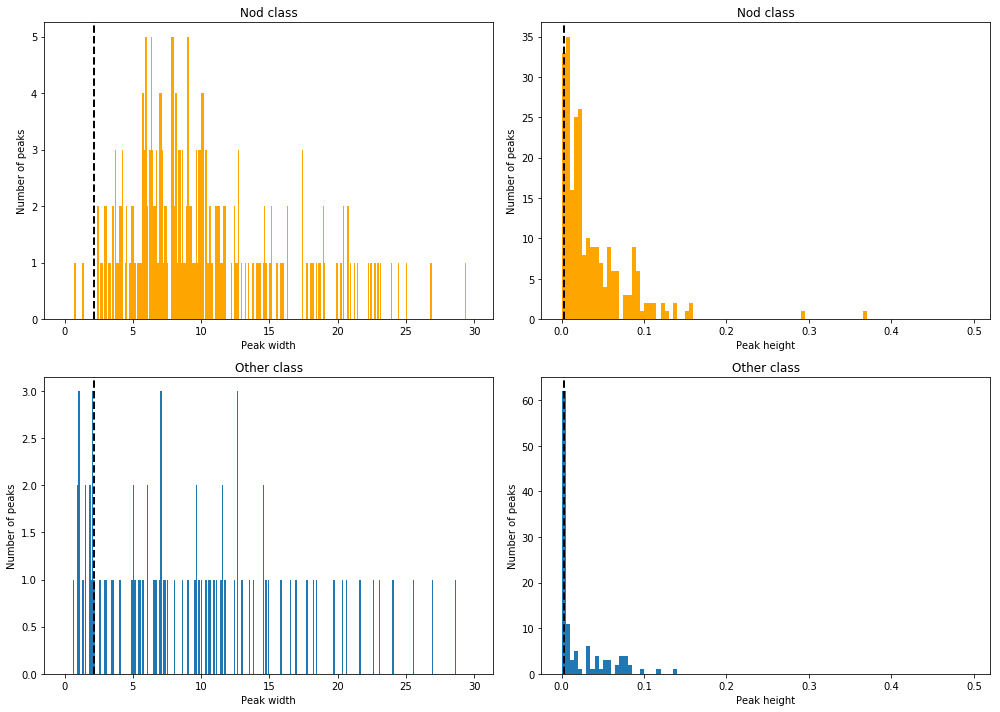

In [256]:
width_bins = np.arange(0, 30, 0.1)
height_bins = np.arange(0, 0.5, 0.005)

plt.figure(figsize=(14,10))
print('Distribution of peak widths and heights')

plt.subplot(2, 2, 1)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
plt.title('Nod class')
plt.hist(nod_x_widths, bins=width_bins, color='orange')
plt.axvline(x=width_threshold, linewidth=2, linestyle='--', color='k')
plt.ylabel('Number of peaks')
plt.xlabel('Peak width')

plt.subplot(2, 2, 2)
plt.title('Nod class')
plt.hist(nod_x_heights, bins=height_bins, color='orange')
plt.axvline(x=height_threshold, linewidth=2, linestyle='--', color='k')
plt.ylabel('Number of peaks')
plt.xlabel('Peak height')

plt.subplot(2, 2, 3)
plt.title('Other class')
plt.hist(other_x_widths, bins=width_bins)
plt.axvline(x=width_threshold, linewidth=2, linestyle='--', color='k')
plt.ylabel('Number of peaks')
plt.xlabel('Peak width')

plt.subplot(2, 2, 4)
plt.title('Other class')
plt.hist(other_x_heights, bins=height_bins)
plt.axvline(x=height_threshold, linewidth=2, linestyle='--', color='k')
plt.ylabel('Number of peaks')
plt.xlabel('Peak height')

plt.tight_layout()
plt.show()

In [143]:
# def plot_4distributions(data, thresholds, head_class): #egends, title, xlabel):
#     """data[0] are assumed to be above the threshold, i.e. the positive class"""
   
#     plt.figure()
# #     
    
#     plt.subplot(2, 2, 1)
#     plt.plot(nod_x_widths)
    
#     plt.subplot(2, 2, 2)
#     plt.plot(nod_x_widths, +)
    
#     plt.subplot(2, 2, 3)
#     plt.plot(nod_x_widths, 'o')
    
#     plt.subplot(2, 2, 4)
#     plt.plot(nod_x_widths, 'x')
    
    
# #     plt.title(title)
# #     for dat, legend in zip(data, legends):
# #         plt.hist(dat, bins=1000, label=legend)
# #     plt.axvline(x=threshold, linewidth=2, linestyle='--', color='k', label='Best threshold')
# #     plt.xlabel(xlabel)
# #     plt.legend()
#     plt.show()

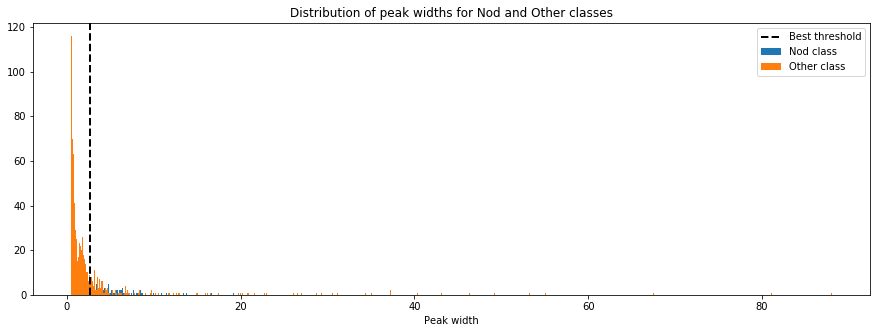

In [15]:
plot_2distributions(data=(nod_x_widths, other_x_widths), threshold=best_threshold, legends=('Nod class', 'Other class'), 
                    title='Distribution of peak widths for Nod and Other classes', xlabel='Peak width')

In [33]:
other_x_widths

[0.5243959717390294,
 0.5671547604077283,
 1.1635588969545605,
 6.268995890132189,
 0.7322843104381107,
 2.006433763720249,
 2.7440927811261986,
 2.0392927096269844,
 1.5964747437897628,
 0.6350939417864367,
 1.0539334740910604,
 1.0208616762076446,
 0.5343880729870278,
 2.2104692652480935,
 0.7942508285972707,
 1.9883064702300288,
 2.2626807765652472,
 0.689629196807175,
 0.6307432590420063,
 2.0824677822061943,
 2.2879543663926114,
 26.51605969326434,
 1.5235714261460203,
 1.9053546428234398,
 0.6205041954361548,
 3.8975311630953797,
 1.118673134931612,
 0.7623226538923404,
 1.6293332185323663,
 0.7257790420625128,
 0.988166342727169,
 1.5698014119485322,
 1.039199046339803,
 1.081292802432614,
 3.184724805982066,
 1.0606577401028439,
 1.514646411301312,
 0.9373954643094073,
 0.5468698384354642,
 1.8644442355412494,
 4.401998358471566,
 3.6397395507726245,
 0.5009203488622376,
 0.6215607913073882,
 0.529445003096825,
 0.590775316512655,
 36.28869679469391,
 0.603161932485933,
 0.8496

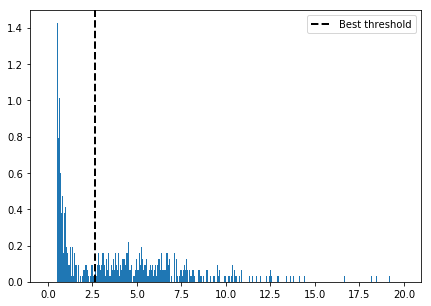

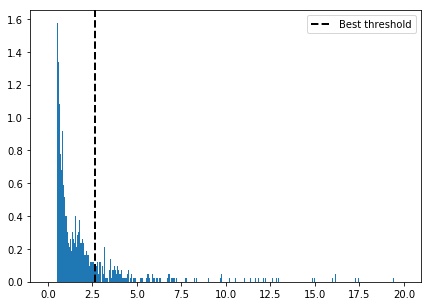

In [41]:
plt.figure(figsize=(7, 5))
# plt.title(title)
plt.hist(nod_x_widths, density=True, stacked=True, bins=np.arange(0, 20, 0.05))
# plt.hist(nod_x_widths, bins=100)
plt.axvline(x=best_threshold, linewidth=2, linestyle='--', color='k', label='Best threshold')
# plt.xlabel(xlabel)
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
# plt.title(title)
plt.hist(other_x_widths, density=True, stacked=True, bins=np.arange(0, 20, 0.05))
# plt.hist(nod_x_widths, bins=100)
plt.axvline(x=best_threshold, linewidth=2, linestyle='--', color='k', label='Best threshold')
# plt.xlabel(xlabel)
plt.legend()
plt.show()

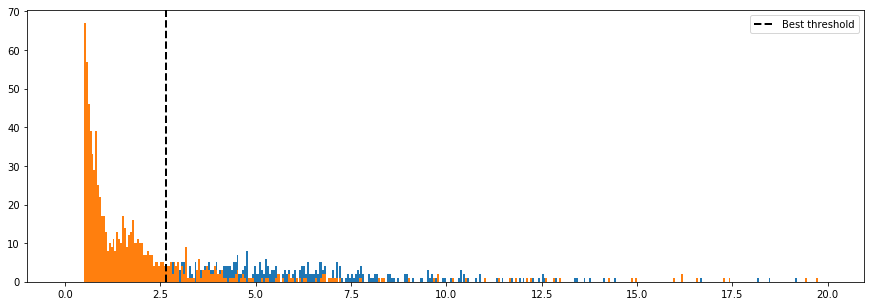

In [39]:
plt.figure(figsize=(15, 5))
# plt.title(title)
plt.hist(nod_x_widths, bins=np.arange(0, 20, 0.05))
plt.hist(other_x_widths, bins=np.arange(0, 20, 0.05))
# plt.hist(nod_x_widths, bins=100)
plt.axvline(x=best_threshold, linewidth=2, linestyle='--', color='k', label='Best threshold')
# plt.xlabel(xlabel)
plt.legend()
plt.show()

Best threshold: 3.0
Accuracy: 0.6904290429042904


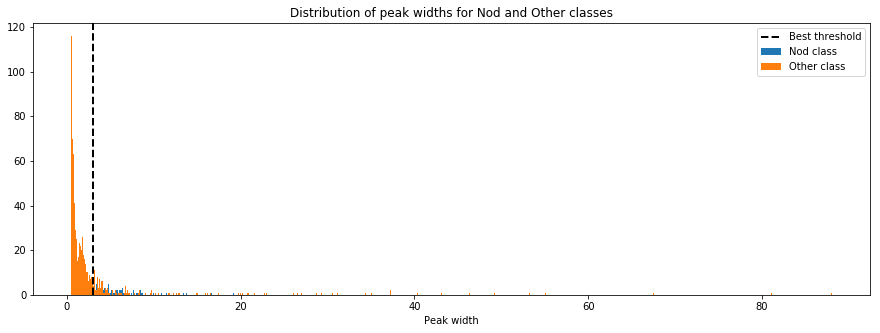

Best threshold: 0.024
Accuracy: 0.7405940594059406


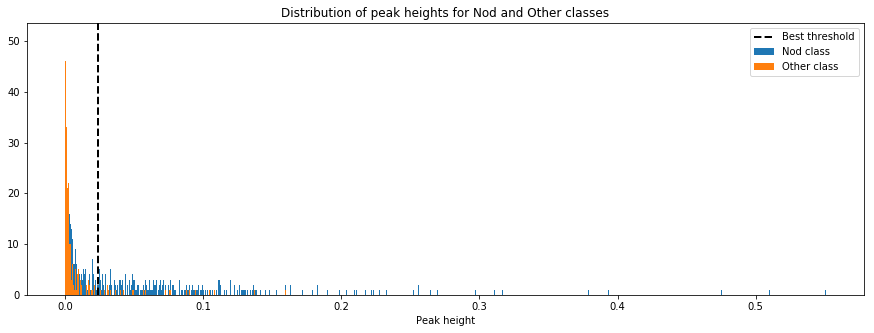

In [12]:


plot_2distributions(data=(nod_x_widths, other_x_widths), legends=('Nod class', 'Other class'), 
                    title='Distribution of peak widths for Nod and Other classes', xlabel='Peak width')

plot_2distributions(data=(nod_x_heights, other_x_heights), legends=('Nod class', 'Other class'), 
                    title='Distribution of peak heights for Nod and Other classes', xlabel='Peak height', 
                    threshold_range=np.arange(0, 0.1, 0.0005))
=np.arange(0, 20, 0.05)

# 2. Shake vs other

In [9]:
shake_y_widths, shake_y_heights = get_peaks_params(head_class='shake', angle_type=angle_type_prefix+'y')
other_y_widths, other_y_heights = get_peaks_params(head_class='other', angle_type=angle_type_prefix+'y')


Best threshold: 3.85
Accuracy: 0.7105901374292644


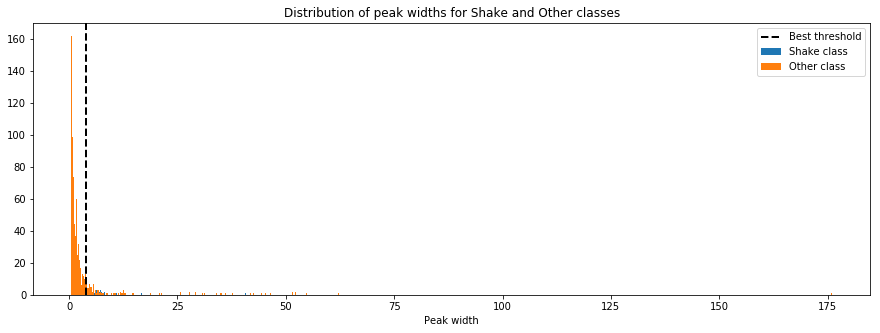

Best threshold: 0.05
Accuracy: 0.8156831042845594


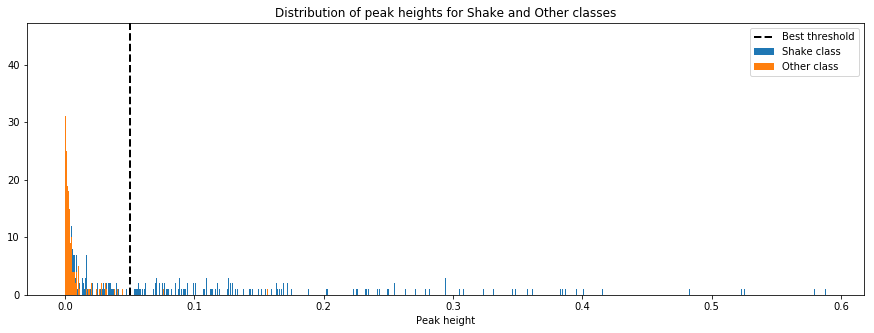

In [13]:
plot_2distributions(data=(shake_y_widths, other_y_widths), legends=('Shake class', 'Other class'), 
                    title='Distribution of peak widths for Shake and Other classes', xlabel='Peak width')

plot_2distributions(data=(shake_y_heights, other_y_heights), legends=('Shake class', 'Other class'), 
                    title='Distribution of peak heights for Shake and Other classes', xlabel='Peak height', 
                    threshold_range=np.arange(0, 0.1, 0.005))
